# Wrangle data

After cleaning the data formats and removing missing values and outliers, the notebook will be dedicted to transform the data into usuable and appropriate formats for machine learning models.

In [2]:
# import the necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# accessing google with the files 
from google.colab import drive
drive.mount('/content/drive')
drive_path = 'drive/My Drive/STAT447 - Predicting Airbnb prices in Vancouver - Team 10/'

Mounted at /content/drive


In [3]:
# import the data from the csv file 
df_clean = pd.read_csv(drive_path + '02a_cleaned_data_airbnb_vancouver.csv', index_col=0)
df_clean.head()

,accommodates,avail_365,price,no_reviews_year,min_nights,review_scores_rating,host_since,host_is_superhost,neighbourhood,latitude,longitude,property_type,room_type,beds,amenities,max_nights
18024.0,6,17,150.0,0.0,30,5.0,2010-01-10,0.0,Kensington-Cedar Cottage,49.247810,-123.072410,House,Private room,3,"[""Freezer"", ""Fire pit"", ""Shower gel"", ""Smoke a...",365
796603.0,1,0,30.0,0.0,30,5.0,2012-11-20,0.0,West End,49.280870,-123.135250,Rental Unit,Shared room,1,"[""Elevator"", ""Heating"", ""TV with standard cabl...",60
2217245.0,2,27,99.0,0.0,2,5.0,2014-01-14,0.0,Fairview,49.259997,-123.141666,Rental Unit,Private room,1,"[""Mountain view"", ""Free dryer \u2013 In unit"",...",10
2710628.0,2,326,124.0,0.0,3,5.0,2013-06-25,0.0,Hastings-Sunrise,49.265231,-123.035652,Guest House,Private room,1,"[""Aveeno conditioner"", ""42\"" TV with Netflix"",...",28
2876573.0,2,97,165.0,0.0,30,5.0,2009-11-10,0.0,Downtown,49.289450,-123.126650,Rental Unit,Entire home/apt,1,"[""Free parking on premises"", ""Wifi"", ""Building...",365


In [24]:
# import the data for topic probabilities from the csv file (from LDA)
df_topic_probs = pd.read_csv(drive_path + '02b_wrangled_data_airbnb_vancouver_lda.csv', index_col=0)
df_topic_probs.head()

,topic1,topic2,topic3
id,,,
13358.0,0.771023,0.135530,0.093447
13490.0,0.108545,0.441551,0.449905
14267.0,0.001035,0.245246,0.753719
14424.0,0.001113,0.276618,0.722270
16254.0,0.143996,0.854835,0.001169


In [4]:
# transform the date columns into a usuable format for prediction models
def transform_dates(df):
    '''
    @inputs: clean dataframe of listings 
    @outputs : pandas dataframe 
    @purpose: given a city's  clean airbnb dataset, this functions converts the datetime columns to days from date until today 
              for better usuability in the machine learning model
    '''
    # compute the day today
    datenow = pd.to_datetime(np.repeat(datetime.datetime.now().date(), len(df)))

    # calulcate the days from now until the respective date for the first and last review and host start date
    date_columns = ["host_since"]
    for column in date_columns: 
      df[column] = pd.to_datetime(df[column])
      datenow = pd.to_datetime(np.repeat(datetime.datetime.now().date(), len(df)))
      df[column] = (datenow - df[column]).dt.days

    return df

In [5]:
df_trans = transform_dates(df_clean)

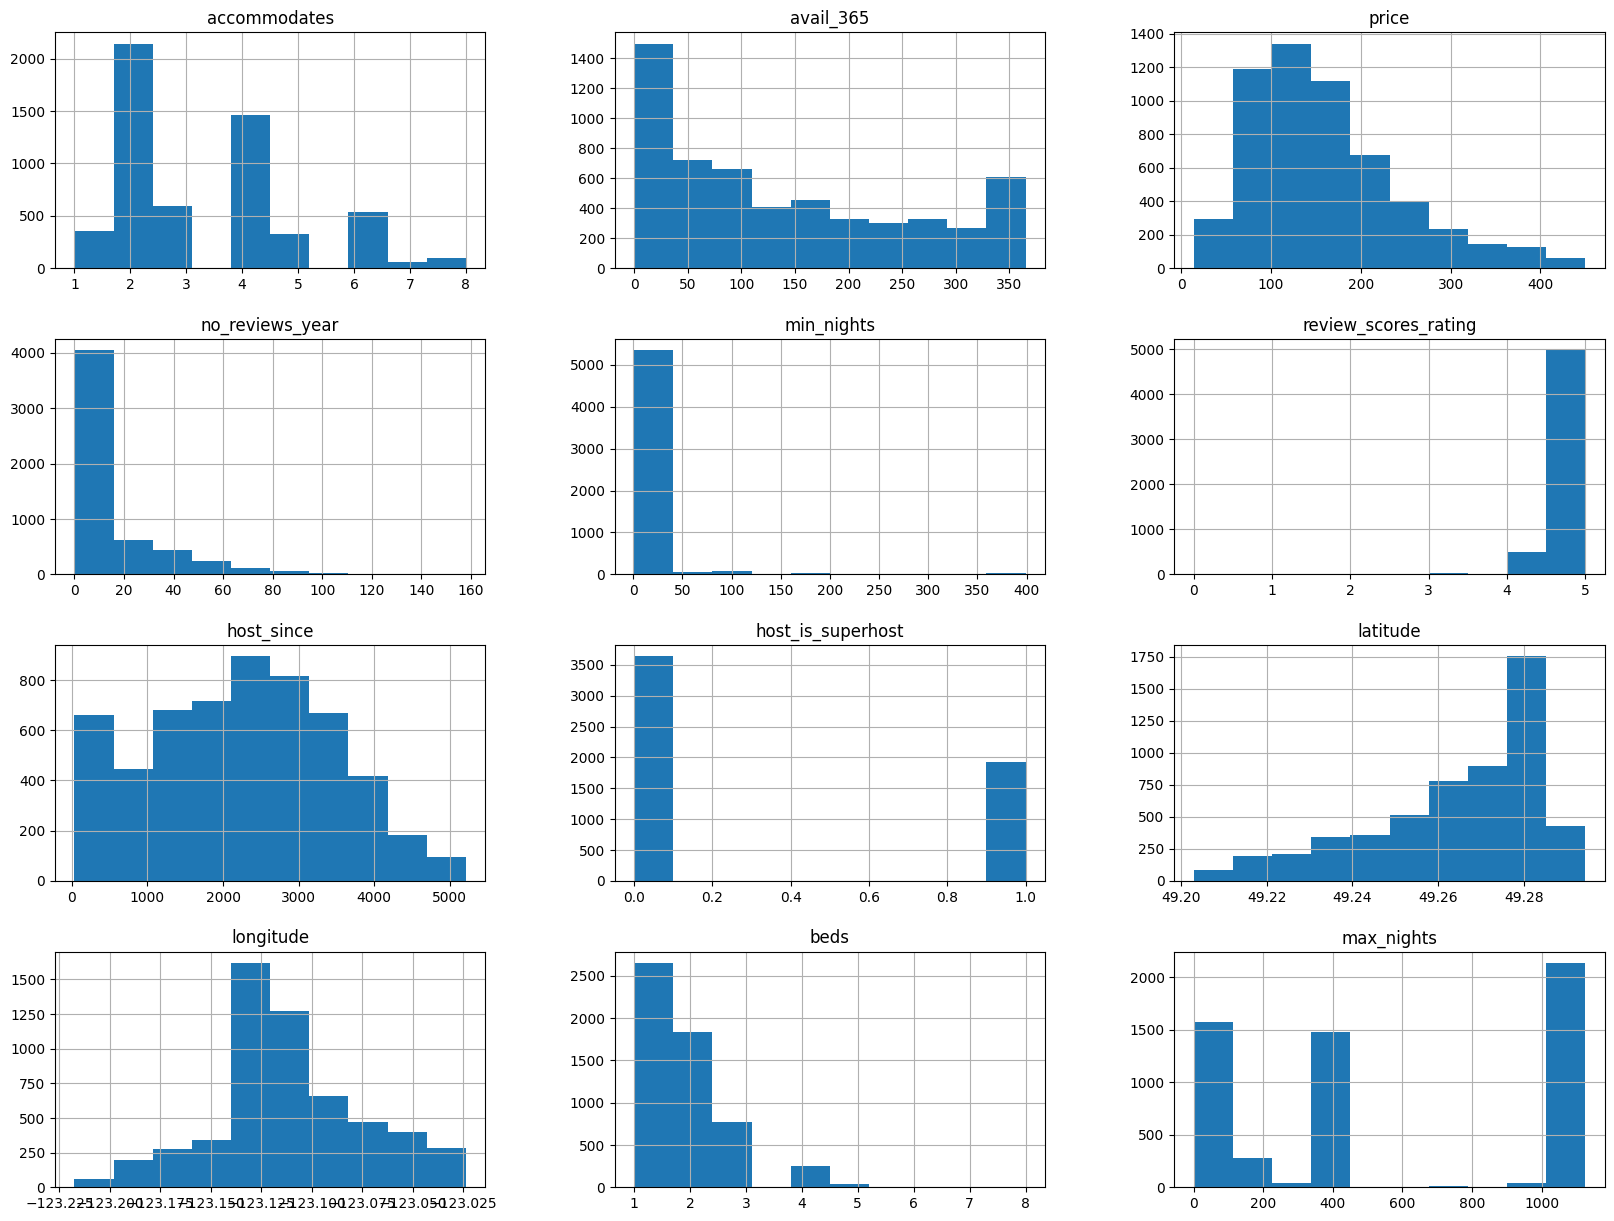

In [6]:
# plot the histograms of the data 
df_trans.hist(figsize=(20, 15))
plt.show()

For heavily skewed features the different transformations log and sqareroot will be tried.

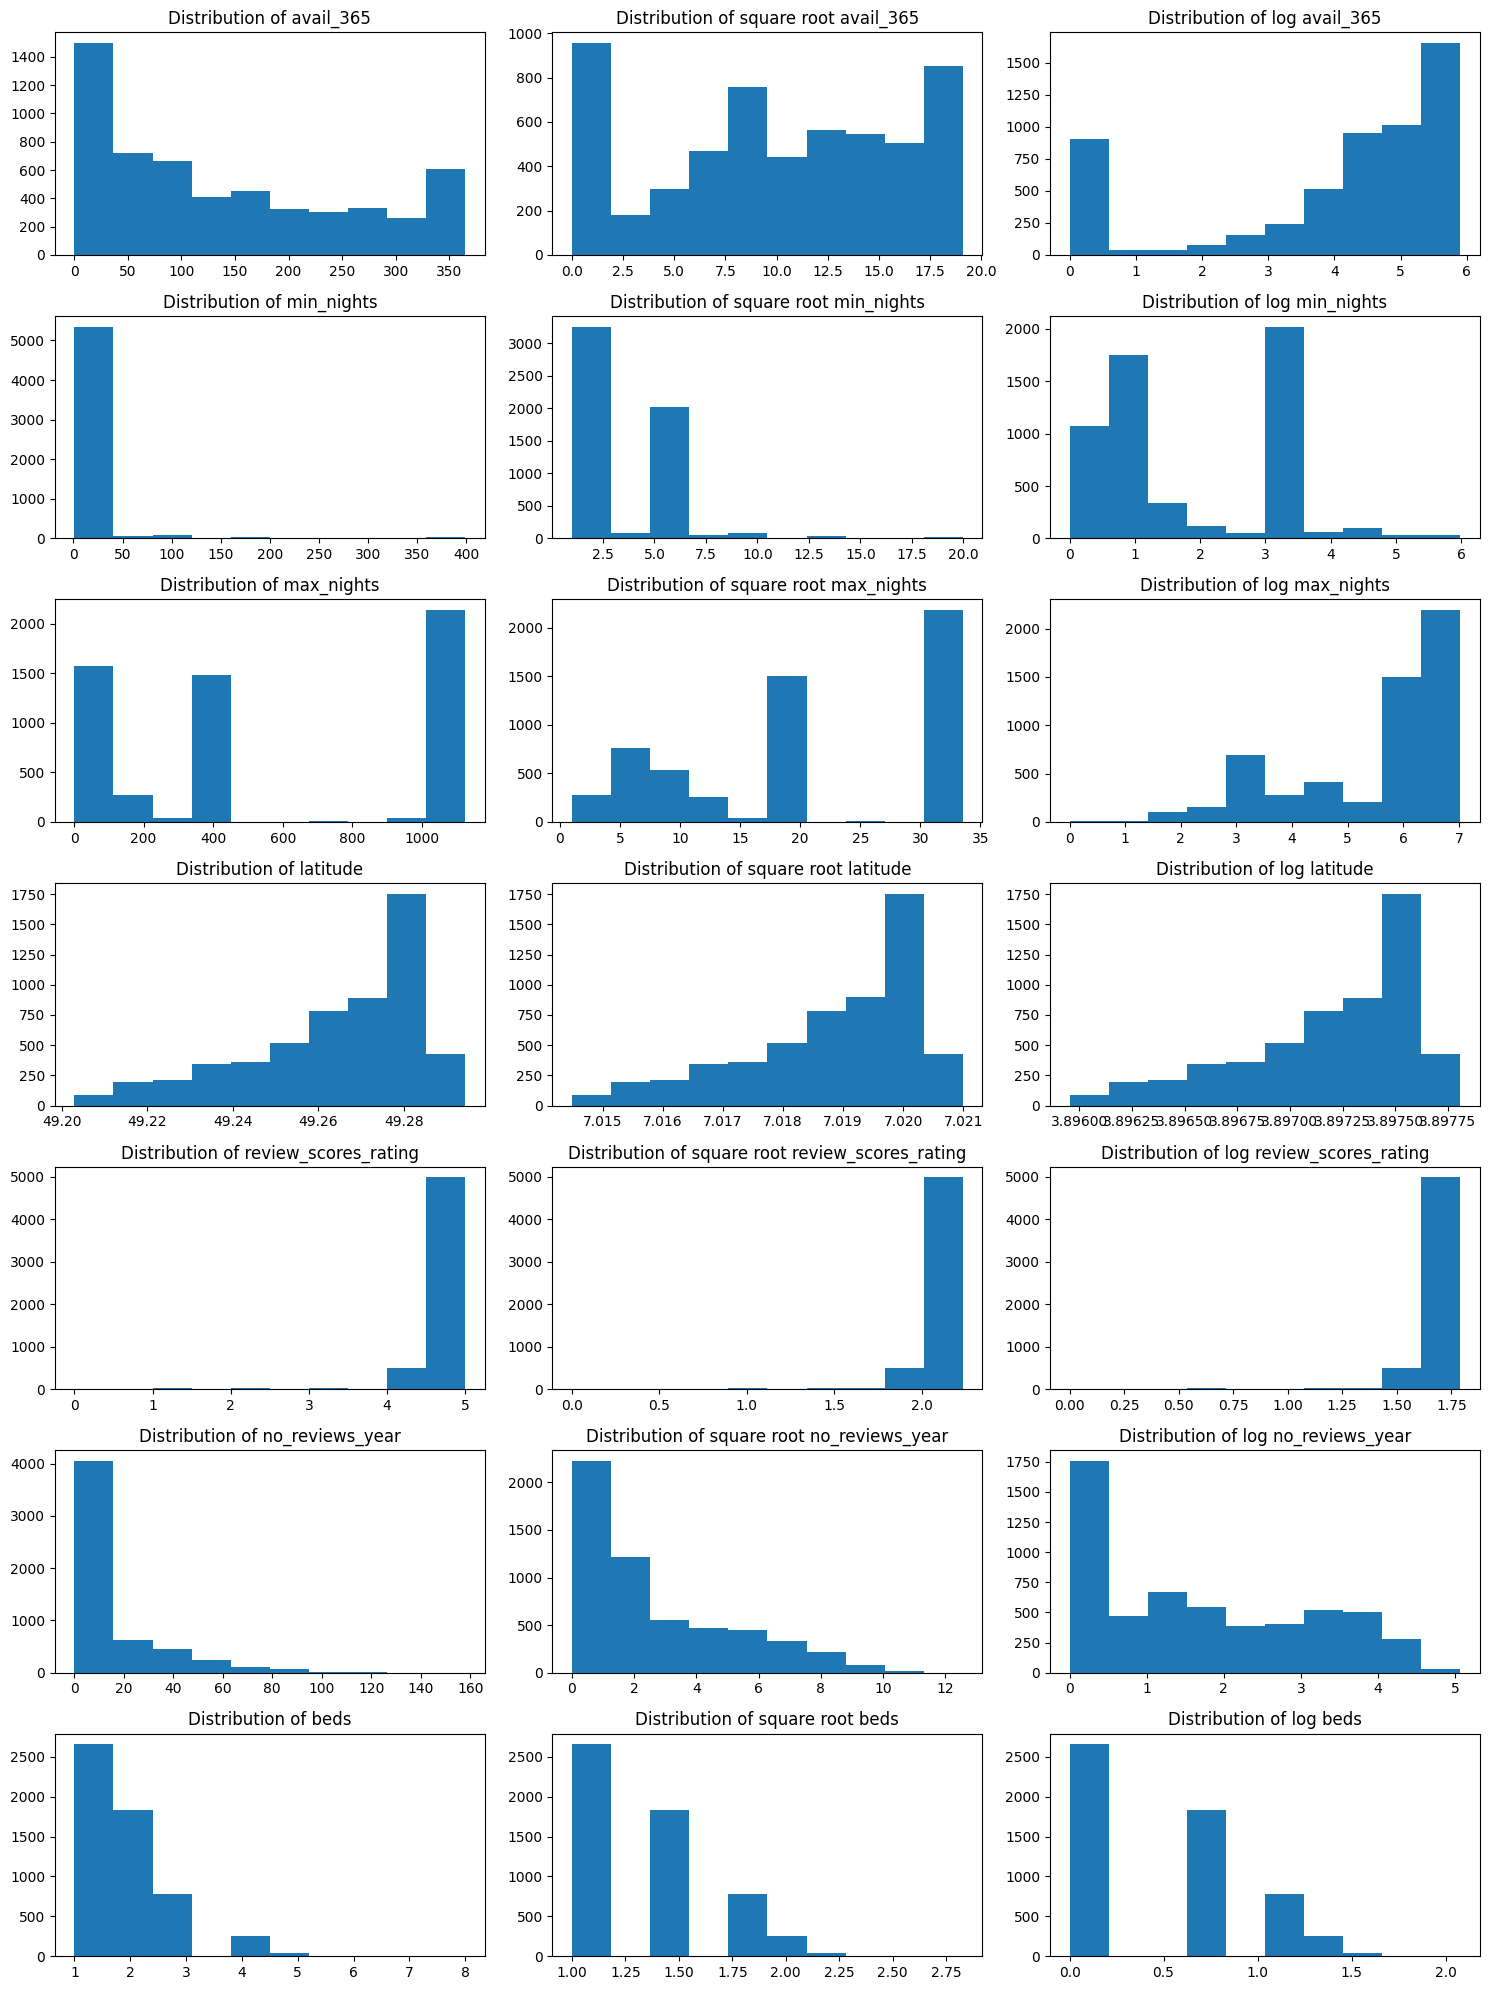

In [7]:
from scipy import stats
plt.figure(figsize=(15,20))
skewed_columns = ['avail_365', 'min_nights', 'max_nights', 'latitude', 'review_scores_rating', 'no_reviews_year', 'beds']
i = 1
for column in skewed_columns:
  plt.subplot(7, 3, i)
  plt.title("Distribution of " + column)
  plt.hist(df_trans[column])

  plt.subplot(7, 3, i+1)
  plt.title("Distribution of square root " + column)
  plt.hist(np.sqrt(df_trans[column]))

  if column == 'review_scores_rating' or column == 'avail_365' or column =='no_reviews_year':
    # deal with 0s in column by adding a constant
    df_trans[column] += 1
  
  plt.subplot(7, 3, i+2)
  plt.title("Distribution of log " + column)
  plt.hist(np.log(df_trans[column]))
  i += 3
plt.tight_layout()

The transformations do not show improvements for the skewed data so they will not be applied. As the linear model is not expected to be the most accurate and forests for instance are not relying on data transformations, the skewedness of the data is not expected to be a serious issue.

In [33]:
# add topic probabilities to df
df_topics = pd.merge(df_trans, df_topic_probs, left_index=True, right_index=True, how='right')
df_topics.head()

,accommodates,avail_365,price,no_reviews_year,min_nights,review_scores_rating,host_since,host_is_superhost,neighbourhood,latitude,...,max_nights,Wifi,Kitchen,Microwave,Fridge,Self check-in,Hair dryer,topic1,topic2,topic3
id,,,,,,,,,,,,,,,,,,,,,
13358.0,2,213,157.0,11.0,2,6.0,4906,1.0,West End,49.28201,...,90,1,1,1,0,0,1,0.771023,0.135530,0.093447
13490.0,2,153,150.0,5.0,30,6.0,4905,1.0,Kensington-Cedar Cottage,49.25622,...,180,1,1,1,0,0,1,0.108545,0.441551,0.449905
14267.0,4,1,150.0,1.0,3,6.0,4893,0.0,Kensington-Cedar Cottage,49.24922,...,7,1,1,1,0,0,1,0.001035,0.245246,0.753719
14424.0,2,71,110.0,8.0,30,6.0,4890,0.0,Downtown Eastside,49.27921,...,1125,1,1,1,0,1,1,0.001113,0.276618,0.722270
16254.0,4,195,350.0,3.0,3,6.0,4868,0.0,Hastings-Sunrise,49.27721,...,31,1,1,1,0,1,1,0.143996,0.854835,0.001169


In [34]:
def transform_dummies(df):
    '''
    @inputs: clean and transform dataframe of listings 
    @outputs : pandas dataframe 
    @purpose: given a city's  clean and transformed airbnb dataset, this functions deals with the textual data in the property type and amenities and transforms the dataset into 
              a dataset with dummies 
    '''

    # recategorizing property type
    property_type_map = {'Entire condo': 'Apartment', 'Entire rental unit': 'Rental Unit', 'Entire home': 'House', 'Entire guest suite': 'Guest House', 'Private room in home': 'House', 'Entire loft': 'Apartment',
    'Private room in rental unit': 'Rental Unit', 'Entire townhouse': 'Townhouse', 'Private room in condo': 'Apartment', 'Entire serviced apartment': 'Apartment', 'Entire guesthouse': 'Guest House','Private room in villa': 'Other', 
    'Private room in guest suite': 'Guest House','Private room in townhouse': 'Townhouse', 'Entire villa': 'Other', 'Room in boutique hotel': 'Other','Private room in bed and breakfast': 'Other', 'Entire bungalow': 'House', 
    'Shared room in rental unit': 'Rental Unit', 'Entire place': 'Other', 'Tiny home': 'Other','Room in aparthotel': 'Other', 'Entire vacation home': 'House', 'Private room in bungalow': 'House', 'Entire timeshare': 'Other',
    'Private room in guesthouse': 'Guest House', 'Shared room in loft': 'Apartment', 'Entire cottage': 'House','Shared room in hostel': 'Other', 'Camper/RV': 'Other', 'Shared room in home': 'House', 'Private room in resort': 'Other',
    'Private room in serviced apartment': 'Apartment', 'Room in bed and breakfast': 'Other', 'Private room in hostel': 'Other', 'Room in hotel': 'Other','Private room in loft': 'House', 'Boat': 'Other',
    'Private room in vacation home': 'House', 'Shared room in bed and breakfast': 'Other', 'Private room in casa particular': 'Other', 'Shared room in villa': 'House', 'Private room in boat': 'Other','Tower': 'Other',
    'Entire cabin': 'House','Private room in tiny home': 'Other', 'Private room in camper/rv': 'Other', 'Floor': 'Other','Private room in cottage': 'House','Shared room in condo': 'Apartment'}

    df['property_type'] = df['property_type'].map(property_type_map)

    # get the main amenities
    df['Wifi'] = df['amenities'].str.contains('Wifi')
    df['Kitchen'] = df['amenities'].str.contains('Kitchen')
    df['Microwave'] = df['amenities'].str.contains('Microwave')
    df['Fridge'] = df['amenities'].str.contains('Fridge')
    df['Self check-in'] = df['amenities'].str.contains('Self check-in')
    df['Hair dryer'] = df['amenities'].str.contains('Hair dryer')
    for column in df.iloc[:,-6:]:
      df[column] = df[column].replace({True:1, False:0})

    df = df.drop('amenities', axis=1)

    # transform to dummies
    for col in ['neighbourhood', 'property_type', 'room_type']:
      df[col] = df[col].astype('category')

    # define our features 
    features = df.drop("price", axis=1)    
    num_feats = features.select_dtypes(include=['float64', 'int64', 'bool']).copy()

    # one-hot encoding of categorical features
    cat_feats = features.select_dtypes(include=['category']).copy()
    cat_feats = pd.get_dummies(cat_feats)


    df_dummy = pd.concat([num_feats, cat_feats, df["price"]], axis=1)
    df_dummy.set_index(df.index)

    return df_dummy

In [35]:
df_dummy = transform_dummies(df_topics)
df_dummy

,accommodates,avail_365,no_reviews_year,min_nights,review_scores_rating,host_since,host_is_superhost,latitude,longitude,beds,...,neighbourhood_Strathcona,neighbourhood_Sunset,neighbourhood_Victoria-Fraserview,neighbourhood_West End,neighbourhood_West Point Grey,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,price
id,,,,,,,,,,,,,,,,,,,,,
1.335800e+04,2,213,11.0,2,6.0,4906,1.0,49.282010,-123.126690,1,...,0,0,0,1,0,1,0,0,0,157.0
1.349000e+04,2,153,5.0,30,6.0,4905,1.0,49.256220,-123.066070,1,...,0,0,0,0,0,1,0,0,0,150.0
1.426700e+04,4,1,1.0,3,6.0,4893,0.0,49.249220,-123.081390,2,...,0,0,0,0,0,1,0,0,0,150.0
1.442400e+04,2,71,8.0,30,6.0,4890,0.0,49.279210,-123.088350,1,...,0,0,0,0,0,1,0,0,0,110.0
1.625400e+04,4,195,3.0,3,6.0,4868,0.0,49.277210,-123.040860,3,...,0,0,0,0,0,1,0,0,0,350.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8.452841e+17,4,309,1.0,1,6.0,34,0.0,49.237248,-123.104728,2,...,0,0,0,0,0,1,0,0,0,104.0
8.458546e+17,2,241,1.0,30,6.0,2702,0.0,49.269547,-123.110062,1,...,0,0,0,0,0,1,0,0,0,120.0
8.458918e+17,8,359,1.0,1,6.0,2389,0.0,49.216332,-123.055613,4,...,0,0,1,0,0,1,0,0,0,339.0


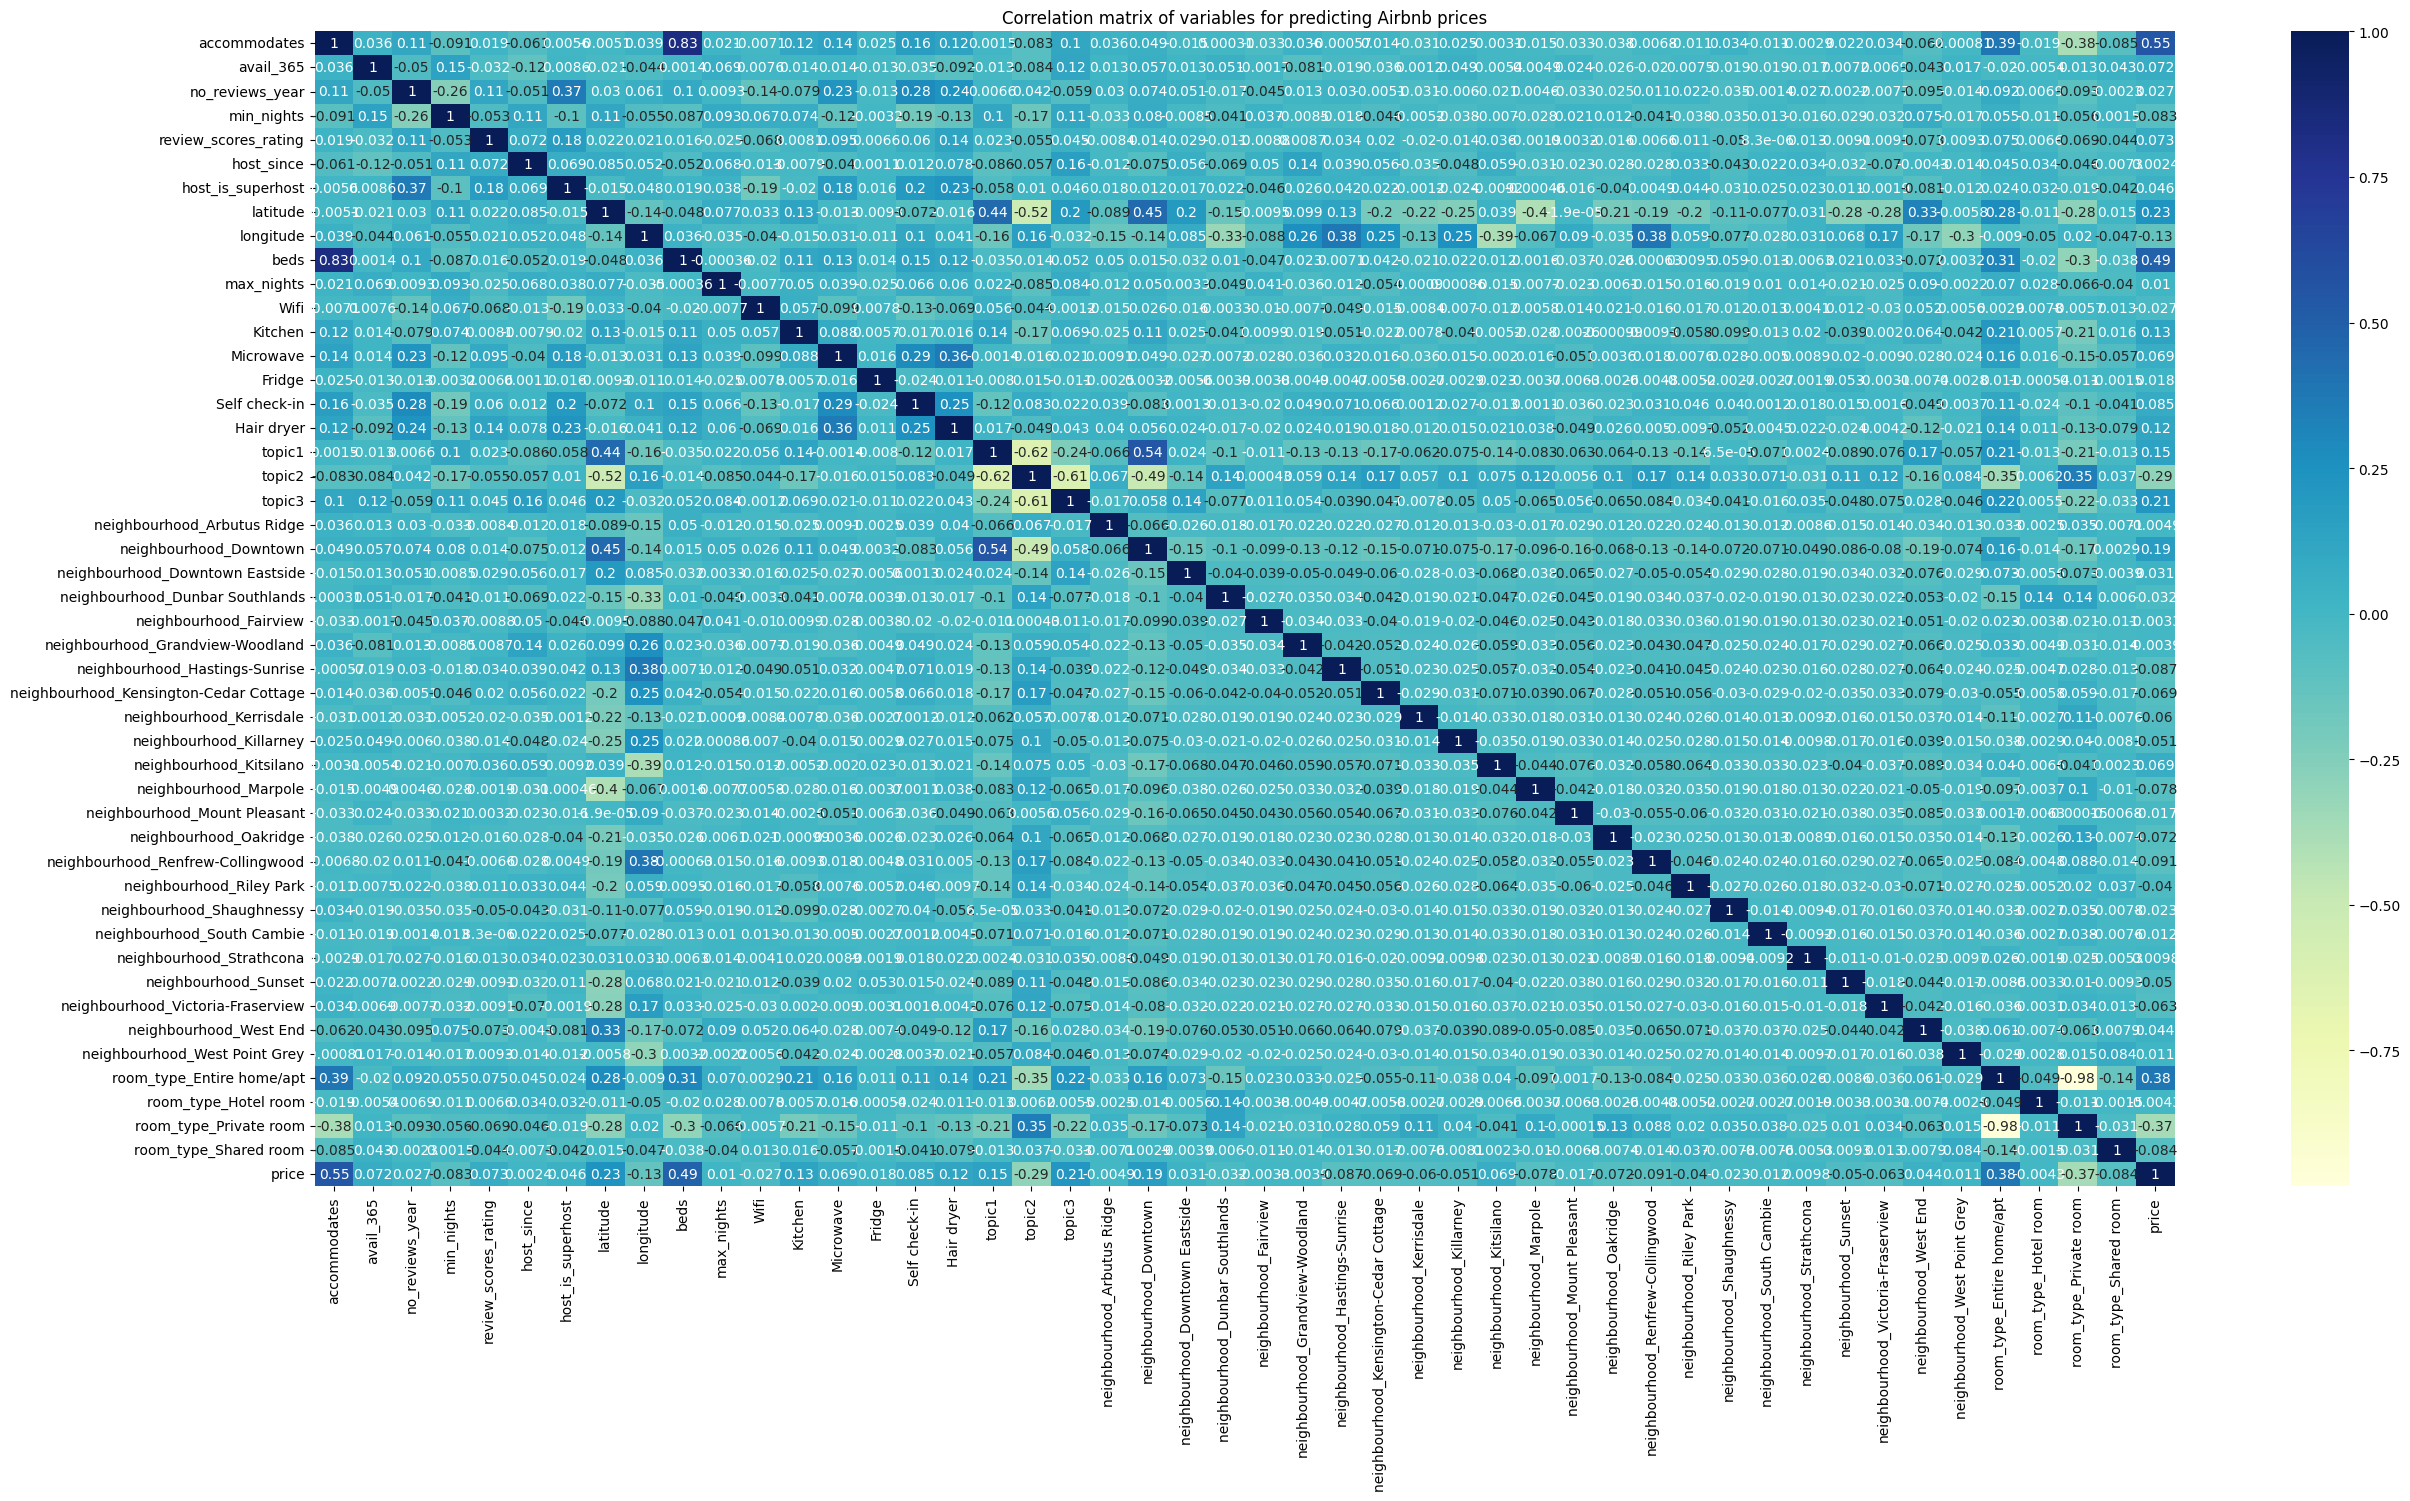

In [36]:
# # plot the data correlations
plt.figure(figsize=(30,15))
sns.heatmap(df_dummy.corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation matrix of variables for predicting Airbnb prices")
plt.show()

In [38]:
df_dummy.to_csv(drive_path +"02b_wrangled_data_airbnb_vancouver.csv")